In [116]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso

In [117]:
rng = np.random.default_rng(0)
n = 1000
X = rng.normal(size=n)
eps = rng.normal(size=n)

In [118]:
X.shape

(1000,)

In [119]:
beta0, beta1, beta2, beta3 = -10, 2, -5, 4
Y = beta0 + beta1*X + beta2*X**2 + beta3*X**3 + eps

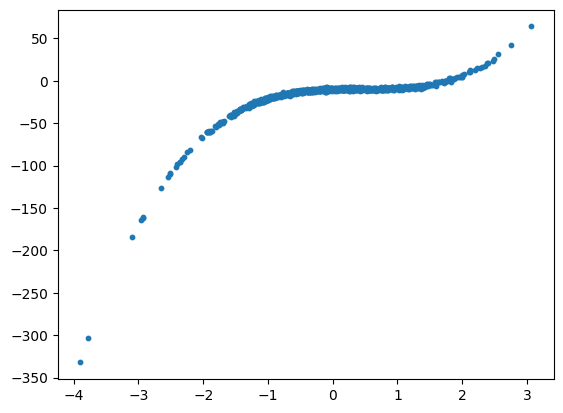

In [120]:
plt.scatter(X, Y, s=10)

In [121]:
columns = [f'X^{i}' for i in range(1, 11)]
print(columns)

d = {name: col for name, col in zip(columns, [X**i for i in range(1, 11)])}
data = pd.DataFrame(d)
data['Y'] = Y
data.head()

['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']


,X^1,X^2,X^3,X^4,X^5,X^6,X^7,X^8,X^9,X^10,Y
0,0.125730,0.015808,0.001988,0.000250,0.000031,0.000004,4.966812e-07,6.244784e-08,7.851581e-09,9.871810e-10,-8.635728
1,-0.132105,0.017452,-0.002305,0.000305,-0.000040,0.000005,-7.021528e-07,9.275780e-08,-1.225376e-08,1.618781e-09,-10.056863
2,0.640423,0.410141,0.262664,0.168216,0.107729,0.068992,4.418418e-02,2.829655e-02,1.812175e-02,1.160558e-02,-9.527151
3,0.104900,0.011004,0.001154,0.000121,0.000013,0.000001,1.397757e-07,1.466249e-08,1.538097e-09,1.613466e-10,-9.574659
4,-0.535669,0.286942,-0.153706,0.082336,-0.044105,0.023625,-1.265545e-02,6.779139e-03,-3.631377e-03,1.945217e-03,-14.487028


Mallow's $C_p$ is defined as:

$$C_p = \frac{1}{n}(RSS + 2d\hat{\sigma}^2)$$

In [122]:
# Compute Cp
def nCp(sigma2, estimator, X, Y):
    "Cp statistic. The full model should yield p+1"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y-Yhat)**2)
    #print('sigma2 | RSS:', sigma2, RSS)
    return (RSS + 2*p*sigma2)/n

In [123]:
# Fit model to data
def fit_model(model, X, y, sigma2):
    model_fitted = model.fit(X, y)

    Cp = nCp(sigma2, model_fitted, X, y)
    return Cp

In [124]:
# Compute sigma for the complete model
y = data['Y']

model = LinearRegression().fit(data[columns], y)
y_pred = model.predict(data[columns])
sigma2 = sum((y-y_pred)**2)/X.shape[0]

In [125]:
# Forward stepwise selection
current_columns = []
cp_values = []
for _ in range(len(columns)):
    best_cp = float('inf')
    best_col = ''
    for col in columns:
        if col not in current_columns:
            X = data[current_columns + [col]]
            cp = fit_model(LinearRegression(), X, y, sigma2)
            if cp < best_cp:
                best_col = col
                best_cp = cp
            #print(cp)
    current_columns.append(best_col)
    print(current_columns)
    cp_values.append(best_cp)

print(current_columns)

['X^3']
['X^3', 'X^2']
['X^3', 'X^2', 'X^1']
['X^3', 'X^2', 'X^1', 'X^4']
['X^3', 'X^2', 'X^1', 'X^4', 'X^6']
['X^3', 'X^2', 'X^1', 'X^4', 'X^6', 'X^5']
['X^3', 'X^2', 'X^1', 'X^4', 'X^6', 'X^5', 'X^7']
['X^3', 'X^2', 'X^1', 'X^4', 'X^6', 'X^5', 'X^7', 'X^9']
['X^3', 'X^2', 'X^1', 'X^4', 'X^6', 'X^5', 'X^7', 'X^9', 'X^8']
['X^3', 'X^2', 'X^1', 'X^4', 'X^6', 'X^5', 'X^7', 'X^9', 'X^8', 'X^10']
['X^3', 'X^2', 'X^1', 'X^4', 'X^6', 'X^5', 'X^7', 'X^9', 'X^8', 'X^10']


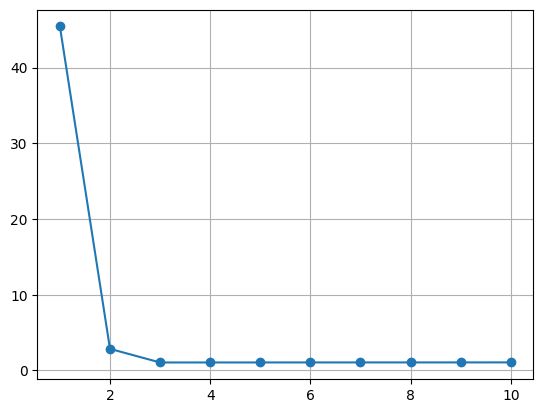

In [126]:
plt.plot(list(range(1, 11)), cp_values, marker='o')
plt.grid()

As we can see from the $C_p$ values obtained, and the plot, that we should choose only three predictors: $X_1$, $X_2$, $X_3$.

In [127]:
best_columns = ['X^1', 'X^2', 'X^3']
best_model = LinearRegression().fit(data[best_columns], y)
score = best_model.score(data[best_columns], y)
coefs = best_model.coef_
interc = best_model.intercept_
print(score, coefs, interc)

0.9978701390701795 [ 2.02803774 -4.99549098  4.01086494] -10.008752312416407


In [128]:
# Backwards stepwise selection
current_columns = columns[:] # Start with all columns
cp_values = []
for _ in range(len(columns)-1):
    print(current_columns)
    X = data[current_columns]
    best_cp = fit_model(LinearRegression(), X, y, sigma2)
    cp_values.append(best_cp)
    worst_col = ''
    for i, col in enumerate(columns):
        if col in current_columns:
            print('X:', current_columns[:i] + current_columns[i+1:])
            X = data[current_columns[:i] + current_columns[i+1:]] # All columns except index i
            cp = fit_model(LinearRegression(), X, y, sigma2)
            if cp <= best_cp:
                worst_col = col
                best_cp = cp
            #print(cp)
    if worst_col == '':
        current_columns.pop(-1)
    else:
        current_columns.pop(current_columns.index(worst_col))
    #print(current_columns)
cp_values.append(best_cp)
print(current_columns)

['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']
X: ['X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']
X: ['X^1', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']
X: ['X^1', 'X^2', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']
X: ['X^1', 'X^2', 'X^3', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']
X: ['X^1', 'X^2', 'X^3', 'X^4', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10']
X: ['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^7', 'X^8', 'X^9', 'X^10']
X: ['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^8', 'X^9', 'X^10']
X: ['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^9', 'X^10']
X: ['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^10']
X: ['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9']
['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9']
X: ['X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9']
X: ['X^1', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9']
X: ['X^1', 'X^2', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9']
X: ['

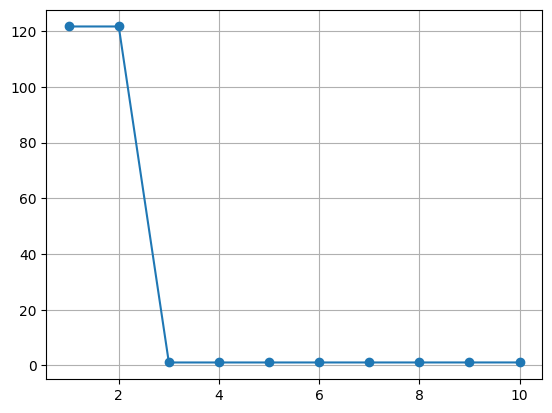

In [129]:
plt.plot(list(range(10, 0, -1)), cp_values, marker='o')
plt.grid()

In [175]:
# Lasso

alphas = np.linspace(0.01, 3, 200)
y = data['Y']
# c = []
# x1 = []
# x2 = []
# x3 = []
# x4 = []
# x5 = []
# x6 = []
scores = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    X = data[columns]
    lasso.fit(X, y)
    scores.append(lasso.score(X, y))
    #print('score:', alpha, lasso.score(X, y))
    # c.append(lasso.coef_)
    # x1.append(lasso.coef_[0])
    # x2.append(lasso.coef_[1])
    # x3.append(lasso.coef_[2])
    # x4.append(lasso.coef_[3])
    # x5.append(lasso.coef_[4])
    # x6.append(lasso.coef_[5])

c:\Users\carlo\OneDrive\Documents\Python\ISLP\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.247e+02, tolerance: 4.890e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\carlo\OneDrive\Documents\Python\ISLP\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.840e+02, tolerance: 4.890e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\carlo\OneDrive\Documents\Python\ISLP\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

0.9978744893002545 0


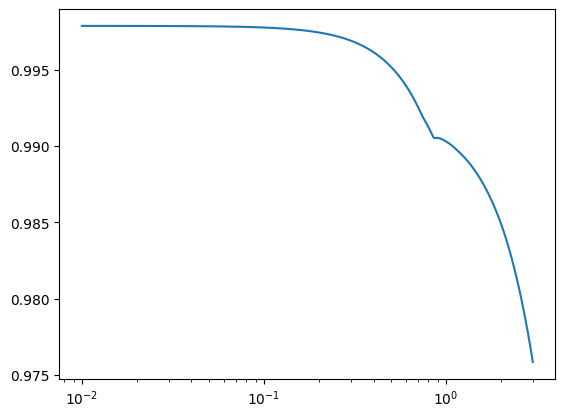

In [176]:
alpha_x = np.log(alphas)
plt.plot(alphas, scores)
plt.xscale('log')
# plt.yscale('log')
# plt.plot(alpha_x, x1, label='x1')
# plt.plot(alpha_x, x2, label='x2')
# plt.plot(alpha_x, x3, label='x3')
# plt.plot(alpha_x, x4, label='x4')
# plt.plot(alpha_x, x5, label='x5')
# plt.plot(alpha_x, x6, label='x6')
# plt.legend()
print(max(scores), np.argmax(scores))

In [132]:
lasso = Lasso(alpha=0.01)
y = data['Y']
X = data[columns]
lasso.fit(X, y)
lasso.coef_

c:\Users\carlo\OneDrive\Documents\Python\ISLP\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.247e+02, tolerance: 4.890e+01
  model = cd_fast.enet_coordinate_descent(


array([ 2.05706575e+00, -4.87108911e+00,  3.95654352e+00, -4.40726199e-02,
        1.44550869e-02,  4.85025729e-03, -7.44138972e-04, -5.81634892e-05,
       -3.37447763e-05, -1.61740895e-05])

c:\Users\carlo\OneDrive\Documents\Python\ISLP\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28580.933447379328, tolerance: 73.57322544864915
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\carlo\OneDrive\Documents\Python\ISLP\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2365.809061422886, tolerance: 73.57322544864915
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\carlo\OneDrive\Documents\Python\ISLP\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 835.5709504391998, tolerance: 73.57322544864915
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\carlo\

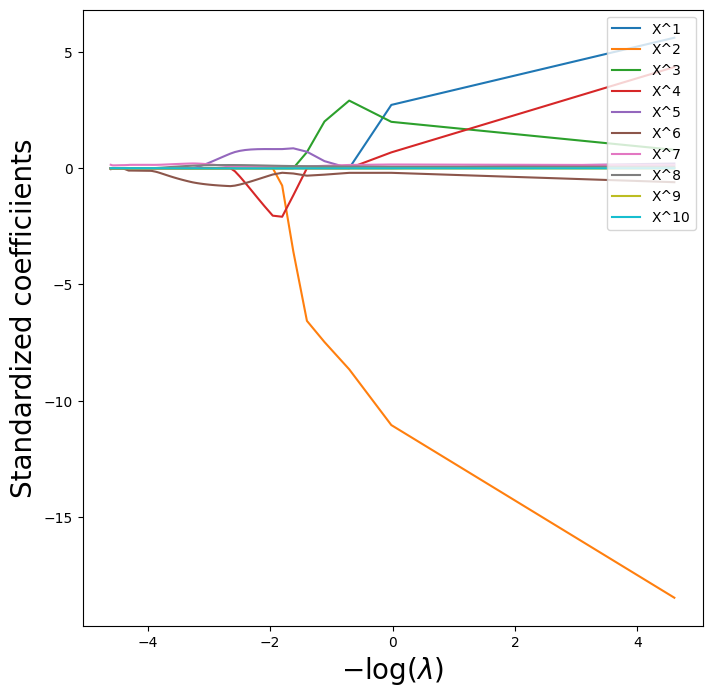

In [159]:
alphas = np.linspace(0.01, 100, 100)
lambdas , soln_array = Lasso.path(X,
    y,
    l1_ratio=1,
    n_alphas=100,
    alphas=alphas)[:2]
soln_path = pd.DataFrame(soln_array.T,
    columns=columns,
    index=-np.log(lambdas))

path_fig, ax = plt.subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper right')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);